In [ ]:
# WGAN-CIFAR10
# Sadegh Sadeghi Tabas
# sadeghs@clemson.edu

# Requirement Package: Tensorflow 1.15

In [2]:
# Import libraries
import time
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from numpy import log
from numpy.random import shuffle
from scipy.linalg import sqrtm
from skimage.transform import resize
import os
from tqdm import tqdm 
from urllib.request import urlretrieve
import tarfile
import os

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
# tf_device='/gpu:1'

In [4]:
# Load and extract the CIFAR10 dataset

"""
cifar10_dataset_folder_path = 'cifar-10-batches-py'
class DownloadProgress(tqdm):
    last_block = 0
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
    urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
        'cifar-10-python.tar.gz', pbar.hook)
        
with tarfile.open('cifar-10-python.tar.gz') as tar:
    tar.extractall()
    tar.close()
"""

# the cifar10 dataset ==>> 0:airplane 1:automobile 2:bird 3:cat 4:deer 5:dog 6:fox 7:horse 8:ship 9:truck

"\ncifar10_dataset_folder_path = 'cifar-10-batches-py'\nclass DownloadProgress(tqdm):\n    last_block = 0\n    def hook(self, block_num=1, block_size=1, total_size=None):\n        self.total = total_size\n        self.update((block_num - self.last_block) * block_size)\n        self.last_block = block_num\n        \nwith DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:\n    urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',\n        'cifar-10-python.tar.gz', pbar.hook)\n        \nwith tarfile.open('cifar-10-python.tar.gz') as tar:\n    tar.extractall()\n    tar.close()\n"

In [5]:
# fuction to create the required directories
def createDirectories():
    if not os.path.isdir('checkpoint_dcgan'):
        os.mkdir('checkpoint_dcgan')
    if not os.path.isdir('trainingLog_dcgan'):
        os.mkdir('trainingLog_dcgan')
    if not os.path.isdir('images_dcgan'):
        os.mkdir('images_dcgan')
    if not os.path.isdir('training_data'):
        os.mkdir('training_data')    

In [6]:
# function to show output images
def showImg(img,index,nums):
    fig, axes = plt.subplots(figsize=( nums+2,len(index)+2), nrows=len(index), ncols=nums, sharey=True, sharex=True)
    if len(index) == 1:
        for ax,img in zip(axes.flatten(),img[index[0]]):
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            ax.imshow(img)
    else:
        for ax_row, idx in zip(axes, index):
            img_row = img[idx][0:nums]
            for image, ax in zip(img_row,ax_row):
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                ax.imshow(imag)
    fig.tight_layout(pad=0)
    plt.show()

In [7]:
# batch normalization
def batch_norm(data):
    from sklearn.preprocessing import MinMaxScaler
    minmax = MinMaxScaler()
    data = minmax.fit_transform(data)
    return data

In [8]:
def dataBatch(data, label, dataSize, labelSize, isShuffle, batchSize):
    capacity = 500 
    data.set_shape(dataSize)
    label.set_shape(labelSize)
    min_after_dequeue = 2 * batchSize 

    if isShuffle:
        [data_batch, label_batch] = tf.train.shuffle_batch([data,label],batch_size=batchSize,capacity=capacity,
                                                       min_after_dequeue=min_after_dequeue)
    else:
        [data_batch,label_batch] = tf.train.batch([data,label],batch_size=batchSize,capacity=capacity)

    return [data_batch, label_batch]

In [9]:
# function to read from training data
def readTraining(sameName, isShuffle, datatype, labeltype, isMultithreading):
    fileslist = tf.train.match_filenames_once(sameName)
    filename_queue = tf.train.string_input_producer(fileslist,shuffle=isShuffle)
    reader = tf.TFRecordReader()
    _,serialization = reader.read(filename_queue)
    if isMultithreading:
        qr = tf.train.QueueRunner(filename_queue, [serialization] * 7)
        tf.train.add_queue_runner(qr)
    features = tf.parse_single_example(
        serialization,
        features={
            "data": tf.FixedLenFeature([],tf.string), 
            "label": tf.FixedLenFeature([],tf.string) 
        })
    data = tf.decode_raw(features["data"], datatype)
    label = tf.decode_raw(features['label'], labeltype)

    return [data,label]

In [10]:
def Int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def Bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [11]:
# function to write the record
def saveTrainingData(data, label, filename, npart):
    dir, file = os.path.split(filename)
    if not os.path.isdir(dir):
        print('build directory..'%(dir))
        os.mkdir(dir)
    index = np.int32(np.linspace(0,data.shape[0],npart+1))

    for i in range(npart):
        suffix = "-%.1d-of-%.1d"%(i+1,npart)
        newname = filename + suffix
        writer = tf.python_io.TFRecordWriter(newname)
        for j in range(index[i],index[i+1]):
            data_to_string = data[j].tobytes()
            label_to_string = label[j].tobytes()
            feature = {
                "data": Bytes_feature(data_to_string),
                "label": Bytes_feature(label_to_string),
            }
            features = tf.train.Features(feature=feature) 
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())
        writer.close()
    fileSets = os .listdir(dir)
    print(fileSets)

In [12]:
# function to load CIFAR10 data
def loadCifar10_class(cifarPath, kind):
    fo = open(cifarPath, 'rb')
    cifar10_dict  = pickle.load(fo, encoding='bytes')
    cifar10_label = cifar10_dict.get(b'labels')
    cifar10_data = cifar10_dict.get(b'data')
    L = [label for label in cifar10_label if label == kind]
    C = [cifar10_data[label[0]] for label in enumerate(cifar10_label) if label[1] == kind]
    C = np.array(C)
    L = np.array(L)
    fo.close()
    return C, L

# read the whole CIFAR10 data
def loadCifar10AllClasses(kind):
    C, L = loadCifar10_class(r'./cifar-10-batches-py/data_batch_1', kind)
    for i in range(2, 6):
        filename = './/cifar-10-batches-py//data_batch_' + str(i)
        data, label = loadCifar10_class(filename, kind)
        C = np.concatenate((C, data))
        L = np.concatenate((L, label))
    return C, L

In [13]:
# function to scale the images
def scaleImages(images, new_shape):
    images_list = list()
    for image in images:
        new_image = resize(image, new_shape, 0)
        images_list.append(new_image)
    return np.asarray(images_list)

In [14]:
def batch_preprocess(data_batch):
    batch = sess.run(data_batch)
    
    batch_images = np.reshape(batch, [-1, 3, 32, 32]).transpose((0, 2, 3, 1))
    batch_images = batch_images * 2 - 1
    return  batch_images

In [15]:
# generative network
def generative(z, channel, is_train=True):
    with tf.variable_scope("generator", reuse=(not is_train)):
        layer1 = tf.layers.dense(z, 4 * 4 * 512)
        layer1 = tf.reshape(layer1, [-1, 4, 4, 512])
        layer1 = tf.layers.batch_normalization(layer1, training=is_train,)
        layer1 = tf.nn.relu(layer1)

        layer2 = tf.layers.conv2d_transpose(layer1, 256, 3, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                            bias_initializer=tf.random_normal_initializer(0, 0.02))
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.nn.relu(layer2)

        layer3 = tf.layers.conv2d_transpose(layer2, 128, 3, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                            bias_initializer=tf.random_normal_initializer(0, 0.02))
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.nn.relu(layer3)

        layer4 = tf.layers.conv2d_transpose(layer3, 64, 3, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                            bias_initializer=tf.random_normal_initializer(0, 0.02))
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = tf.nn.relu(layer4)

        logits = tf.layers.conv2d_transpose(layer4, channel, 3, strides=1, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                            bias_initializer=tf.random_normal_initializer(0, 0.02))
        outputs = tf.tanh(logits)
        
        return logits,outputs

In [16]:
# discriminative network
def discriminative(inputs_img, reuse=False, GAN = False, GP= False, alpha=0.2):
    with tf.variable_scope("discriminator", reuse=reuse):
        layer1 = tf.layers.conv2d(inputs_img, 128, 3, strides=2, padding='same')
        if GP is False:
            layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = tf.nn.leaky_relu(layer1,alpha=alpha)

        layer2 = tf.layers.conv2d(layer1, 256, 3, strides=2, padding='same')
        if GP is False:
            layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.nn.leaky_relu(layer2, alpha=alpha)

        layer3 = tf.layers.conv2d(layer2, 512, 3, strides=2, padding='same')
        if GP is False:
            layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.nn.leaky_relu(layer3, alpha=alpha)
        layer3 = tf.reshape(layer3, [-1, 4*4* 512])

        logits = tf.layers.dense(layer3, 1)
 
        if GAN:
            outputs = None
        else:
            outputs = tf.sigmoid(logits)

        return logits, outputs

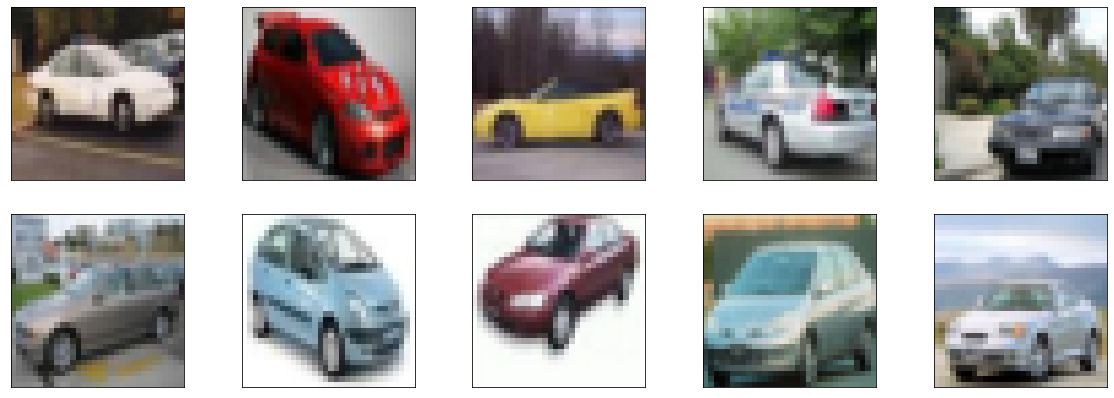

['class_1-4-of-5', 'class_1-1-of-5', 'class_1-5-of-5', 'class_1-3-of-5', 'class_1-2-of-5']


In [67]:
# please select the class of the cifar10 dataset that you want to run the GAN for it

# 0 ==> airplaine
# 1 ==> car
# 2 ==> bird
# 3 ==> cat
# 4 ==> dear
# 5 ==> dog
# 6 ==> fox
# 7 ==> horse
# 8 ==> ship
# 9 ==> truck

createDirectories()

# please put the class number in the function below
C, L = loadCifar10AllClasses(1)
C = batch_norm(C)

# print sample images (real images) 
imgs = C[-11:-1].reshape(-1,3,32,32).transpose((0,2,3,1))
fig, axes = plt.subplots(figsize=(20, 7), nrows=2, ncols=5, sharex=True, sharey=True)
for ax,img in zip(axes.flatten(),imgs):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img)
plt.show()

# save training data
saveTrainingData(C ,L, r'./training_data/class_1', 5)

In [18]:
real_shape = [-1,32,32,3]
data_total = 6000 
batch_size = 64
noise_size = 128 
max_iters = 15000 
learning_rate = 0.0002
criticNUM = 1
smooth = 0.1 # smooth parameter of label, label*(1 - smooth)
beta1 = 0.4 # ADAM parameter
#clip = [-0.1, 0.1]
generateLog = []
losses = []

In [19]:
# inputs data
inputs_real = tf.placeholder(tf.float32, [None, real_shape[1], real_shape[2], real_shape[3]], name='inputs_real')
inputs_noise = tf.placeholder(tf.float32, [None, noise_size], name='inputs_noise')

In [20]:
# generative network (g)
_, g_outputs = generative(inputs_noise, real_shape[3], is_train=True)
_, g_test = generative(inputs_noise, real_shape[3], is_train=False)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


In [21]:
# discriminative network (d)
d_logits_real, _ = discriminative(inputs_real,GAN=True)
d_logits_fake, _ = discriminative(g_outputs,GAN=True,reuse=True)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


In [22]:
# loss function for networks
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake) * (1 - smooth)))
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                     labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))

# discriminative loss integration
d_loss = tf.add(d_loss_real, d_loss_fake)

train_vars  = tf.trainable_variables()
g_vars = [var for var in train_vars  if var.name.startswith("generator")]
d_vars = [var for var in train_vars  if var.name.startswith("discriminator")]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
# Optimizer alg
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars) 
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

In [24]:
# clip
# d_clip_opt = [tf.assign(var, tf.clip_by_value(var, clip[0], clip[1])) for var in d_vars]

# read training data
[data, label] = readTraining(sameName= r'./training_data/class_1-*',isShuffle= False,datatype= tf.float64, labeltype= tf.int64,isMultithreading= True)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


In [25]:
# shuffling data
[data_batch, label_batch] = dataBatch(data,label,dataSize= 32*32*3,labelSize= 1, isShuffle= True, batchSize= 64)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.shuffle(min_after_dequeue).batch(batch_size)`.


In [26]:
# save
saver = tf.train.Saver(var_list=[var for var in tf.trainable_variables() if var.name.startswith("generator")], max_to_keep=5)

In [27]:
with tf.Session() as sess:
    init = (tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    # start timing
    time_start = time.time() 
    for epoch in range(max_iters):
        epoch += 1
        if epoch < 25 or epoch % 500 == 0:
            critic_num = 100
        else:
            critic_num = criticNUM
            
        batch_images = batch_preprocess(data_batch)  # images
        batch_noise = np.random.normal(size=(batch_size, noise_size))  # noise(normal)
        for i in range(criticNUM):
            _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_noise: batch_noise})
            #sess.run(d_clip_opt)
        _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_noise: batch_noise})
        
        #batch_images = batch_preprocess(data_batch)  # images
        #batch_noise = np.random.normal(size=(batch_size, noise_size))  # noise(normal)
        #_ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_noise: batch_noise})
        if epoch % 5 == 1:
            train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_noise: batch_noise})
            train_loss_g = g_loss.eval({inputs_real: batch_images, inputs_noise: batch_noise})
            losses.append([train_loss_d, train_loss_g, epoch])
            batch_noise = np.random.normal(size=(batch_size, noise_size))
            gen_samples = sess.run(g_test, feed_dict={inputs_noise: batch_noise})
            genLog = (gen_samples[0:11] + 1) / 2
            generateLog.append(genLog)
            print('epoch {}/{}...'.format(epoch,max_iters), "Generator Loss: {:.4f}...".format(train_loss_g), "Discriminator Loss: {:.4f}...".format(train_loss_d))
                  
        if epoch % 500 ==0:
            saver.save(sess, './checkpoint_dcgan/generator.ckpt', global_step=epoch)

    coord.request_stop()
    coord.join(threads)
    
# end time
time_end = time.time()
print('elapsed time：%.2f s.'%(time_end-time_start))

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
epoch 1/15000... Generator Loss: 0.3511... Discriminator Loss: 3.3396...
epoch 6/15000... Generator Loss: 0.4265... Discriminator Loss: 1.9971...
epoch 11/15000... Generator Loss: 0.7229... Discriminator Loss: 1.3571...
epoch 16/15000... Generator Loss: 0.8940... Discriminator Loss: 1.0939...
epoch 21/15000... Generator Loss: 1.1051... Discriminator Loss: 0.9229...
epoch 26/15000... Generator Loss: 1.0521... Discriminator Loss: 0.8742...
epoch 31/15000... Generator Loss: 1.5036... Discriminator Loss: 0.6923...
epoch 36/15000... Generator Loss: 2.2281... Discriminator Loss: 0.5750...
epoch 41/15000... Generator Loss: 1.9418... Discriminator Loss: 0.5353...
epoch 46/15000... Generator Loss: 4.9059... Discriminator Loss: 0.4712...
epoch 51/15000... Generator Loss: 1.0858... Discriminator Loss: 0.8473...
epoch 56/15000... Generator Loss: 2.0429... Discriminator Loss: 0.5107...
epoch 61/15000... Generator Los

Saving loss info...
Saving GenerateLog inof..
loss saved
GenerateLog saved..


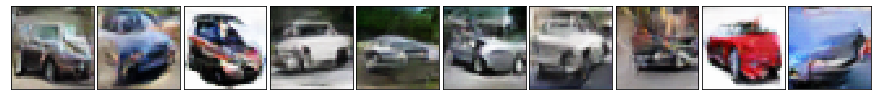

In [28]:
# Save losses and log
with open('./trainingLog_dcgan/loss_variation.loss', 'wb') as l:
    losses = np.array(losses)
    pickle.dump(losses,l)
    print('loss saved')
    
with open('./trainingLog_dcgan/generateLog.log', 'wb') as g:
    pickle.dump(generateLog, g)
    print('GenerateLog saved..')
    
# output
with open('./trainingLog_dcgan/generateLog.log', 'rb') as f:
    generateLog = pickle.load(f)
    generateLog = np.array(generateLog)
    showImg(generateLog,[-1],10)

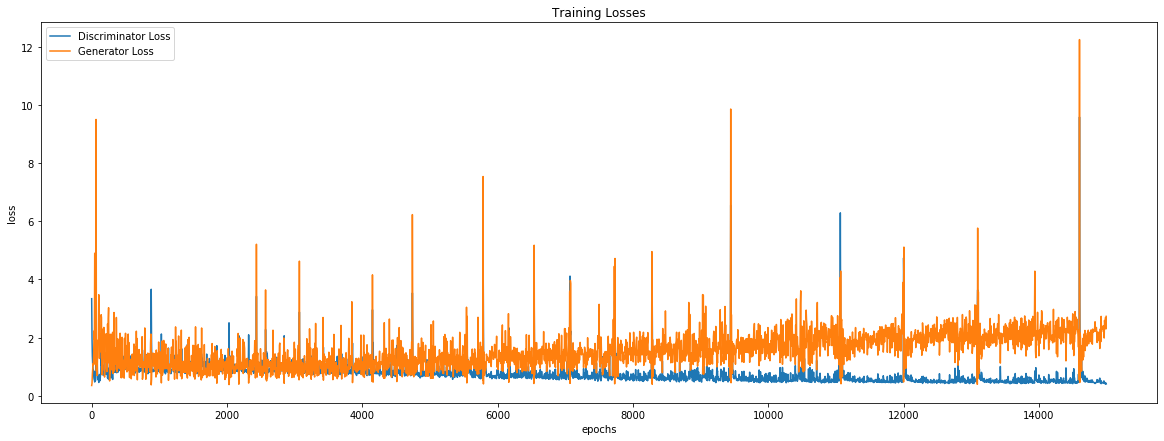

In [29]:
# plot losses
with open(r'./trainingLog_dcgan/loss_variation.loss','rb') as l:
    losses = pickle.load(l)
    fig, ax = plt.subplots(figsize=(20, 7))
    plt.plot(losses.T[2],losses.T[0], label='Discriminator Loss')
    plt.plot(losses.T[2],losses.T[1], label='Generator Loss')
    plt.title("Training Losses")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [ ]:
# test image generation
with tf.Session() as sess:
    meta_graph = tf.train.import_meta_graph('./checkpoint_dcgan/generator.ckpt-15000.meta')
    meta_graph.restore(sess,tf.train.latest_checkpoint('./checkpoint_dcgan'))
    graph = tf.get_default_graph()
    inputs_noise = graph.get_tensor_by_name("inputs_noise:0")
    d_outputs_fake = graph.get_tensor_by_name("generator/Tanh:0")
    sample_noise= np.random.normal(size=(2560, 128))
    gen_samples = sess.run(d_outputs_fake,feed_dict={inputs_noise: sample_noise})
    gen_samples = [(gen_samples[0:2561]+1)/2]
    showImg(gen_samples, [0], 10)
    for i in range(2560):
        img=gen_samples[0][i]
        plt.imshow(img)
        plt.axis('off')
        plt.savefig("images_dcgan/car_%d.png" % i)
        plt.show

In [ ]:
# Shuffling CIFAR10 images and extract 2560 random image to calculate FID score
random.shuffle(C)
images=C[-2561:-1].reshape(-1,3,32,32).transpose((0,2,3,1))
for i in range(2560):
        img=images[i]
        plt.imshow(img)
        plt.axis('off')
        plt.savefig("shuffledCifar/car_%d.png" % i)
